In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [17]:
# ============================
#  create config for DAGMM_base
# ============================
def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set, one_hot=True)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = 0
    for column,dim in discrete_column_dims.items():
        if dim == 2:
            num_discrete_columns+=1
        else:
            num_discrete_columns+= dim
            
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    print('Num real columns :: ', num_real_columns)
    print('Num discrete columns ::', num_discrete_columns)
    
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns 
    for k,v in discrete_column_dims.items():
        if v == 2:
            v = 1
        final_op_dims +=  v
        
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim



def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.05
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    num_anom_sets = 5
    
    for idx in range(1,num_anom_sets+1):
        key = 'anom_' + str(idx)
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1

        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step
        P = [P[0]] + P
        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
        
    print(' Mean AUC ',np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return



    

In [18]:
# =================================== #
data_set = 'kddcup_neptune'
data_dict, _ = data_fetcher.get_data(data_set,True,anomaly_ratio=0.2, num_anom_sets=5)
train_df = data_dict['train']
train_X = train_df.values

Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432


In [19]:
train_df.columns

Index(['protocol_type_0', 'protocol_type_1', 'protocol_type_2', 'service_0',
       'service_1', 'service_2', 'service_3', 'service_4', 'service_5',
       'service_6',
       ...
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object', length=114)

In [20]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432
Num real columns ::  34
Num discrete columns :: 80
{'discrete_column_dims': {'flag': 9,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 65},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [60, 30, 10, 1]},
 'num_discrete': 80,
 'num_real': 34}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 10, 30, 60, 114]},
 'discrete_column_dims': {'flag': 9,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 65},
 'final_output_dim': 114,
 'num_discrete': 80,
 'num_real': 34}


In [22]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=1
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=114, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): Tanh()
      (6): Linear(in_features=60, out_features=114, bias=True)
      (7): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


In [23]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=50,
    batch_size=1024
)

  0%|          | 0/50 [00:00<?, ?it/s]

 , total_loss: 22.0082, sample_energy: -9.5045, recon_error: 0.0960, cov_diag: 4572.5142


  2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

Epoch loss :: 22.156734
 , total_loss: 22.8816, sample_energy: -9.2067, recon_error: 0.0962, cov_diag: 4741.2134


  4%|▍         | 2/50 [00:02<00:50,  1.05s/it]

Epoch loss :: 22.185053
 , total_loss: 22.2648, sample_energy: -9.2139, recon_error: 0.0961, cov_diag: 4618.0088


  6%|▌         | 3/50 [00:03<00:48,  1.03s/it]

Epoch loss :: 22.149445
 , total_loss: 21.9043, sample_energy: -9.1227, recon_error: 0.0961, cov_diag: 4544.0996


  8%|▊         | 4/50 [00:04<00:46,  1.01s/it]

Epoch loss :: 22.214487
 , total_loss: 22.9194, sample_energy: -9.5755, recon_error: 0.0963, cov_diag: 4756.1392


 10%|█         | 5/50 [00:04<00:45,  1.00s/it]

Epoch loss :: 22.205023
 , total_loss: 24.1101, sample_energy: -9.5932, recon_error: 0.0963, cov_diag: 4994.6172


 12%|█▏        | 6/50 [00:05<00:43,  1.00it/s]

Epoch loss :: 22.20556
 , total_loss: 20.6897, sample_energy: -9.3965, recon_error: 0.0960, cov_diag: 4306.6807


 14%|█▍        | 7/50 [00:07<00:44,  1.03s/it]

Epoch loss :: 22.188438
 , total_loss: 22.3620, sample_energy: -9.4608, recon_error: 0.0961, cov_diag: 4642.3970


 16%|█▌        | 8/50 [00:08<00:43,  1.04s/it]

Epoch loss :: 22.176794
 , total_loss: 21.6758, sample_energy: -9.3010, recon_error: 0.0961, cov_diag: 4501.9609


 18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]

Epoch loss :: 22.17753
 , total_loss: 23.3969, sample_energy: -9.5400, recon_error: 0.0963, cov_diag: 4850.9219


 20%|██        | 10/50 [00:10<00:42,  1.06s/it]

Epoch loss :: 22.178064
 , total_loss: 20.4362, sample_energy: -9.1876, recon_error: 0.0959, cov_diag: 4251.8184


 22%|██▏       | 11/50 [00:11<00:40,  1.03s/it]

Epoch loss :: 22.178596
 , total_loss: 20.5982, sample_energy: -9.2028, recon_error: 0.0959, cov_diag: 4284.5220


 24%|██▍       | 12/50 [00:12<00:38,  1.02s/it]

Epoch loss :: 22.17874
 , total_loss: 20.8321, sample_energy: -9.4268, recon_error: 0.0959, cov_diag: 4335.7607


 26%|██▌       | 13/50 [00:13<00:37,  1.01s/it]

Epoch loss :: 22.164204
 , total_loss: 20.9229, sample_energy: -9.4575, recon_error: 0.0961, cov_diag: 4354.5088


 28%|██▊       | 14/50 [00:14<00:35,  1.00it/s]

Epoch loss :: 22.145359
 , total_loss: 23.4995, sample_energy: -9.2221, recon_error: 0.0962, cov_diag: 4865.1006


 30%|███       | 15/50 [00:15<00:34,  1.01it/s]

Epoch loss :: 22.153315
 , total_loss: 20.9593, sample_energy: -9.3196, recon_error: 0.0959, cov_diag: 4359.0591


 32%|███▏      | 16/50 [00:16<00:33,  1.01it/s]

Epoch loss :: 22.231037
 , total_loss: 23.1122, sample_energy: -9.5060, recon_error: 0.0963, cov_diag: 4793.3037


 34%|███▍      | 17/50 [00:17<00:32,  1.01it/s]

Epoch loss :: 22.165619
 , total_loss: 21.3669, sample_energy: -9.3839, recon_error: 0.0961, cov_diag: 4441.8525


 36%|███▌      | 18/50 [00:18<00:31,  1.02it/s]

Epoch loss :: 22.144424
 , total_loss: 22.4364, sample_energy: -9.4885, recon_error: 0.0962, cov_diag: 4657.8008


 38%|███▊      | 19/50 [00:19<00:30,  1.02it/s]

Epoch loss :: 22.186052
 , total_loss: 20.9346, sample_energy: -9.3581, recon_error: 0.0960, cov_diag: 4354.8950


 40%|████      | 20/50 [00:20<00:29,  1.01it/s]

Epoch loss :: 22.200008
 , total_loss: 24.4837, sample_energy: -9.3702, recon_error: 0.0964, cov_diag: 5064.8740


 42%|████▏     | 21/50 [00:21<00:29,  1.00s/it]

Epoch loss :: 22.172472
 , total_loss: 19.9748, sample_energy: -9.3637, recon_error: 0.0959, cov_diag: 4163.0645


 44%|████▍     | 22/50 [00:22<00:28,  1.02s/it]

Epoch loss :: 22.188599
 , total_loss: 22.1456, sample_energy: -9.3231, recon_error: 0.0961, cov_diag: 4596.3599


 46%|████▌     | 23/50 [00:23<00:27,  1.02s/it]

Epoch loss :: 22.167425
 , total_loss: 22.8610, sample_energy: -9.3585, recon_error: 0.0961, cov_diag: 4740.1411


 48%|████▊     | 24/50 [00:24<00:26,  1.01s/it]

Epoch loss :: 22.170792
 , total_loss: 23.1674, sample_energy: -9.4976, recon_error: 0.0962, cov_diag: 4804.1875


 50%|█████     | 25/50 [00:25<00:25,  1.01s/it]

Epoch loss :: 22.176762
 , total_loss: 21.2318, sample_energy: -9.5803, recon_error: 0.0961, cov_diag: 4418.7412


 52%|█████▏    | 26/50 [00:26<00:24,  1.01s/it]

Epoch loss :: 22.185968
 , total_loss: 21.6417, sample_energy: -9.4081, recon_error: 0.0961, cov_diag: 4497.2881


 54%|█████▍    | 27/50 [00:27<00:23,  1.01s/it]

Epoch loss :: 22.176727
 , total_loss: 21.4287, sample_energy: -9.4201, recon_error: 0.0961, cov_diag: 4454.9131


 56%|█████▌    | 28/50 [00:28<00:22,  1.00s/it]

Epoch loss :: 22.17088
 , total_loss: 23.7327, sample_energy: -9.4548, recon_error: 0.0962, cov_diag: 4916.3838


 58%|█████▊    | 29/50 [00:29<00:20,  1.00it/s]

Epoch loss :: 22.190075
 , total_loss: 22.7631, sample_energy: -9.2281, recon_error: 0.0962, cov_diag: 4717.9590


 60%|██████    | 30/50 [00:30<00:19,  1.01it/s]

Epoch loss :: 22.144194
 , total_loss: 21.7623, sample_energy: -9.1829, recon_error: 0.0961, cov_diag: 4516.9141


 62%|██████▏   | 31/50 [00:31<00:18,  1.00it/s]

Epoch loss :: 22.167822
 , total_loss: 21.5690, sample_energy: -9.1355, recon_error: 0.0960, cov_diag: 4477.2959


 64%|██████▍   | 32/50 [00:32<00:18,  1.01s/it]

Epoch loss :: 22.181452
 , total_loss: 19.5145, sample_energy: -8.9797, recon_error: 0.0957, cov_diag: 4063.3408


 66%|██████▌   | 33/50 [00:33<00:17,  1.03s/it]

Epoch loss :: 22.163206
 , total_loss: 22.9175, sample_energy: -9.4524, recon_error: 0.0962, cov_diag: 4753.2998


 68%|██████▊   | 34/50 [00:34<00:16,  1.02s/it]

Epoch loss :: 22.142185
 , total_loss: 22.6435, sample_energy: -9.2287, recon_error: 0.0962, cov_diag: 4694.0342


 70%|███████   | 35/50 [00:35<00:15,  1.03s/it]

Epoch loss :: 22.141459
 , total_loss: 21.9397, sample_energy: -9.1227, recon_error: 0.0961, cov_diag: 4551.1763


 72%|███████▏  | 36/50 [00:36<00:14,  1.03s/it]

Epoch loss :: 22.151262
 , total_loss: 21.5491, sample_energy: -9.2914, recon_error: 0.0960, cov_diag: 4476.4497


 74%|███████▍  | 37/50 [00:37<00:13,  1.04s/it]

Epoch loss :: 22.169918
 , total_loss: 21.7558, sample_energy: -9.4457, recon_error: 0.0960, cov_diag: 4520.8896


 76%|███████▌  | 38/50 [00:38<00:12,  1.03s/it]

Epoch loss :: 22.17005
 , total_loss: 25.3047, sample_energy: -9.6479, recon_error: 0.0965, cov_diag: 5234.6089


 78%|███████▊  | 39/50 [00:39<00:11,  1.01s/it]

Epoch loss :: 22.226349
 , total_loss: 22.0166, sample_energy: -9.3960, recon_error: 0.0962, cov_diag: 4572.0015


 80%|████████  | 40/50 [00:40<00:10,  1.01s/it]

Epoch loss :: 22.219404
 , total_loss: 23.3927, sample_energy: -9.4161, recon_error: 0.0962, cov_diag: 4847.6172


 82%|████████▏ | 41/50 [00:41<00:08,  1.00it/s]

Epoch loss :: 22.148285
 , total_loss: 23.0170, sample_energy: -9.1430, recon_error: 0.0962, cov_diag: 4767.0269


 84%|████████▍ | 42/50 [00:42<00:07,  1.01it/s]

Epoch loss :: 22.177395
 , total_loss: 21.2554, sample_energy: -9.4536, recon_error: 0.0960, cov_diag: 4420.9473


 86%|████████▌ | 43/50 [00:43<00:07,  1.01s/it]

Epoch loss :: 22.17659
 , total_loss: 25.3715, sample_energy: -9.6463, recon_error: 0.0964, cov_diag: 5247.9287


 88%|████████▊ | 44/50 [00:44<00:05,  1.00it/s]

Epoch loss :: 22.17007
 , total_loss: 22.0783, sample_energy: -9.2714, recon_error: 0.0961, cov_diag: 4581.8647


 90%|█████████ | 45/50 [00:45<00:05,  1.00s/it]

Epoch loss :: 22.14484
 , total_loss: 24.0270, sample_energy: -9.2974, recon_error: 0.0962, cov_diag: 4972.1104


 92%|█████████▏| 46/50 [00:46<00:03,  1.00it/s]

Epoch loss :: 22.186245
 , total_loss: 22.4210, sample_energy: -9.2973, recon_error: 0.0962, cov_diag: 4650.9062


 94%|█████████▍| 47/50 [00:47<00:03,  1.01s/it]

Epoch loss :: 22.212404
 , total_loss: 23.7560, sample_energy: -9.2673, recon_error: 0.0962, cov_diag: 4917.3066


 96%|█████████▌| 48/50 [00:48<00:02,  1.03s/it]

Epoch loss :: 22.203959
 , total_loss: 22.8340, sample_energy: -9.5098, recon_error: 0.0962, cov_diag: 4737.7451


 98%|█████████▊| 49/50 [00:49<00:01,  1.02s/it]

Epoch loss :: 22.210073
 , total_loss: 24.8104, sample_energy: -9.4129, recon_error: 0.0963, cov_diag: 5131.0742


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]

Epoch loss :: 22.242971


======================TEST MODE======================
N: 75040
phi : tensor([0.6350, 0.3650], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.0842,  1.1574, -0.0359],
        [-0.0836,  1.1571, -0.0354]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0035, -0.0014,  0.0028],
         [-0.0014,  0.0006, -0.0012],
         [ 0.0028, -0.0012,  0.0024]],

        [[ 0.0036, -0.0015,  0.0029],
         [-0.0015,  0.0006, -0.0012],
         [ 0.0029, -0.0012,  0.0024]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  32161
test_energy (32161,)
(6432,)
(38593,) (38593,)
AUC : 0.8958 


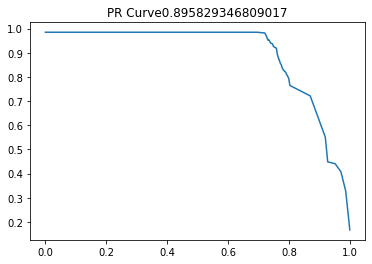

(6432,)
(38593,) (38593,)
AUC : 0.8908 


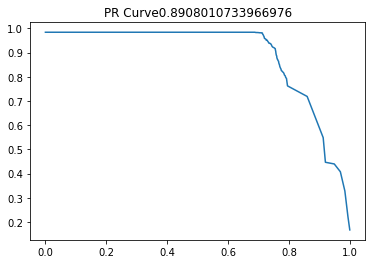

(6432,)
(38593,) (38593,)
AUC : 0.8882 


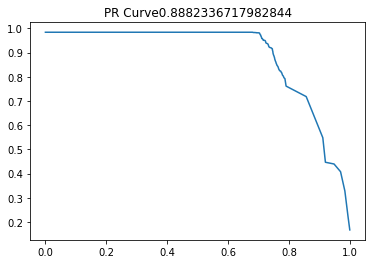

(6432,)
(38593,) (38593,)
AUC : 0.8892 


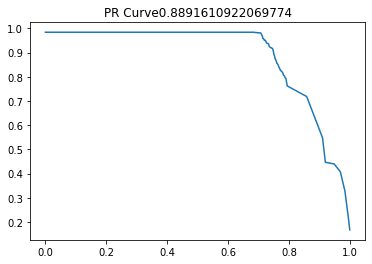

(6432,)
(38593,) (38593,)
AUC : 0.8877 


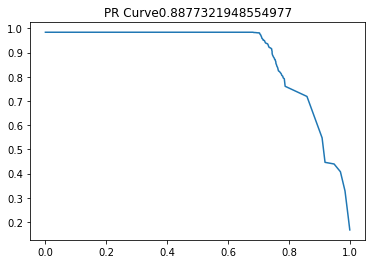

 Mean AUC  0.8903514758132948
 AUC std 0.0029316189501652034


In [25]:
test(
    dagmm_obj,
    data_dict
)